In [1]:
# ===== NEW NOTEBOOK: P15 Station 2019 Seasonal Analysis =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from argopy import DataFetcher
import warnings
warnings.filterwarnings('ignore')


station_name='P15'
year=2019

In [2]:
def analyze_station_seasonal_cycle(station_name, year, results_df=None):
    """
    Analyze seasonal cycle for any Line-P station and year
    
    Parameters:
    -----------
    station_name : str
        Name of the station (e.g., 'P15', 'P4', 'P12', etc.)
    year : int
        Year to analyze (e.g., 2019, 2020, etc.)
    results_df : pandas.DataFrame, optional
        Pre-loaded results dataframe. If None, will try to load from CSV
    """
    
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from argopy import DataFetcher
    import warnings
    warnings.filterwarnings('ignore')

    print(f"=== {station_name} Station {year} Seasonal Cycle Analysis ===\n")

    # Step 1: Load or use provided results data
    if results_df is None:
        if 'results_df' in globals():
            results_df = globals()['results_df']
        else:
            try:
                results_df = pd.read_csv('argo_profiles_near_lineP.csv')
                results_df['date'] = pd.to_datetime(results_df['date'])
                results_df['year'] = results_df['date'].dt.year
                print("Loaded results from CSV file")
            except:
                print("Could not load results data. Please run the Argo search first or provide results_df parameter.")
                return None

    # Filter for specified station and year
    station_data = results_df[
        (results_df['closest_station'] == station_name) & 
        (results_df['year'] == year)
    ].copy()

    if len(station_data) == 0:
        print(f"No Argo profiles found near {station_name} station in {year}")
        print(f"Available stations: {sorted(results_df['closest_station'].unique())}")
        print(f"Available years for {station_name}: {sorted(results_df[results_df['closest_station'] == station_name]['year'].unique())}")
        return None

    print(f"Found {len(station_data)} Argo profiles near {station_name} station in {year}:")
    print(station_data[['profile_id', 'float_id', 'date', 'distance_km']].sort_values('date'))

    # Step 2: Fetch the actual profile data
    print(f"\nFetching detailed profile data...")

    profile_ids = station_data['profile_id'].unique()
    print(f"Unique profiles to fetch: {len(profile_ids)}")

    all_profiles_data = []
    fetcher = DataFetcher()
    successful_fetches = 0

    for i, profile_id in enumerate(profile_ids):
        try:
            print(f"Fetching profile {i+1}/{len(profile_ids)}: {profile_id}")
            
            profile_info = station_data[station_data['profile_id'] == profile_id].iloc[0]
            float_id = profile_info['float_id']
            profile_date = profile_info['date']
            lat = profile_info['latitude']
            lon = profile_info['longitude']

            try:
                if float_id != 'N/A':
                    profile_data = fetcher.region([lon-0.01, lon+0.01, lat-0.01, lat+0.01, 0, 2000, 
                                                  profile_date.strftime('%Y-%m-%d'), 
                                                  (profile_date + pd.Timedelta(days=1)).strftime('%Y-%m-%d')]).load()
                else:
                    profile_data = fetcher.region([lon-0.1, lon+0.1, lat-0.1, lat+0.1, 0, 2000,
                                                  profile_date.strftime('%Y-%m-%d'),
                                                  (profile_date + pd.Timedelta(days=1)).strftime('%Y-%m-%d')]).load()

                df = profile_data.to_dataframe()

                if len(df) > 0:
                    df['profile_id'] = profile_id
                    df[f'distance_to_{station_name}'] = profile_info['distance_km']
                    df['date_profile'] = profile_date
                    df['month'] = profile_date.month
                    df['month_name'] = profile_date.strftime('%B')
                    
                    all_profiles_data.append(df)
                    successful_fetches += 1
                    print(f"  ✓ Success: {len(df)} measurements")
                else:
                    print(f"  ✗ No data returned")

            except Exception as e:
                print(f"  ✗ Error fetching profile: {e}")
                continue

        except Exception as e:
            print(f"  ✗ Error processing profile {profile_id}: {e}")
            continue

    print(f"\nSuccessfully fetched {successful_fetches}/{len(profile_ids)} profiles")

    if successful_fetches == 0:
        print("Could not fetch any profile data.")
        return None

    # Step 3: Combine all profile data
    combined_profiles = pd.concat(all_profiles_data, ignore_index=True)
    print(f"Total measurements: {len(combined_profiles)}")
    print(f"Depth range: {combined_profiles['PRES'].min():.1f} - {combined_profiles['PRES'].max():.1f} dbar")
    print(f"Available parameters: {[col for col in combined_profiles.columns if col.isupper()]}")

    # Step 4: Create seasonal cycle plots
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))

    temp_col = 'TEMP' if 'TEMP' in combined_profiles.columns else None
    sal_col = 'PSAL' if 'PSAL' in combined_profiles.columns else None

    # 4a. Temperature depth-time plot
    if temp_col:
        pivot_temp = combined_profiles.pivot_table(
            values=temp_col, 
            index='PRES', 
            columns='date_profile', 
            aggfunc='mean'
        )
        
        pivot_temp_interp = pivot_temp.interpolate(method='linear', axis=0).interpolate(method='linear', axis=1)
        
        X, Y = np.meshgrid(pivot_temp_interp.columns, pivot_temp_interp.index)
        contour = axes[0,0].contourf(X, Y, pivot_temp_interp.values, levels=20, cmap='RdYlBu_r')
        axes[0,0].contour(X, Y, pivot_temp_interp.values, levels=20, colors='black', alpha=0.3, linewidths=0.5)
        
        cbar1 = plt.colorbar(contour, ax=axes[0,0])
        cbar1.set_label('Temperature (°C)')
        
        axes[0,0].set_ylabel('Pressure (dbar)')
        axes[0,0].set_title(f'Temperature Seasonal Cycle - {station_name} Station {year}', fontsize=14)
        axes[0,0].invert_yaxis()
        axes[0,0].tick_params(axis='x', rotation=45)
        
        for date in pivot_temp.columns:
            axes[0,0].axvline(x=date, color='white', alpha=0.5, linestyle='--', linewidth=1)

    # 4b. Salinity depth-time plot
    if sal_col:
        pivot_sal = combined_profiles.pivot_table(
            values=sal_col, 
            index='PRES', 
            columns='date_profile', 
            aggfunc='mean'
        )
        
        pivot_sal_interp = pivot_sal.interpolate(method='linear', axis=0).interpolate(method='linear', axis=1)
        
        X, Y = np.meshgrid(pivot_sal_interp.columns, pivot_sal_interp.index)
        contour2 = axes[0,1].contourf(X, Y, pivot_sal_interp.values, levels=20, cmap='viridis')
        axes[0,1].contour(X, Y, pivot_sal_interp.values, levels=20, colors='black', alpha=0.3, linewidths=0.5)
        
        cbar2 = plt.colorbar(contour2, ax=axes[0,1])
        cbar2.set_label('Salinity (PSU)')
        
        axes[0,1].set_ylabel('Pressure (dbar)')
        axes[0,1].set_title(f'Salinity Seasonal Cycle - {station_name} Station {year}', fontsize=14)
        axes[0,1].invert_yaxis()
        axes[0,1].tick_params(axis='x', rotation=45)
        
        for date in pivot_sal.columns:
            axes[0,1].axvline(x=date, color='white', alpha=0.5, linestyle='--', linewidth=1)

    # 4c. Temperature profiles by month
    if temp_col:
        months_present = sorted(combined_profiles['month'].unique())
        colors = plt.cm.tab10(np.linspace(0, 1, len(months_present)))
        
        for i, month in enumerate(months_present):
            month_data = combined_profiles[combined_profiles['month'] == month]
            month_name = month_data['month_name'].iloc[0]
            
            temp_profile = month_data.groupby('PRES')[temp_col].mean()
            
            axes[1,0].plot(temp_profile.values, temp_profile.index, 
                          color=colors[i], linewidth=2, 
                          label=f'{month_name} ({len(month_data.groupby("profile_id"))} profiles)')
        
        axes[1,0].set_xlabel('Temperature (°C)')
        axes[1,0].set_ylabel('Pressure (dbar)')
        axes[1,0].set_title(f'Temperature Profiles by Month - {station_name} {year}', fontsize=14)
        axes[1,0].invert_yaxis()
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)

    # 4d. Salinity profiles by month
    if sal_col:
        for i, month in enumerate(months_present):
            month_data = combined_profiles[combined_profiles['month'] == month]
            month_name = month_data['month_name'].iloc[0]
            
            sal_profile = month_data.groupby('PRES')[sal_col].mean()
            
            axes[1,1].plot(sal_profile.values, sal_profile.index,
                          color=colors[i], linewidth=2, label=f'{month_name}')
        
        axes[1,1].set_xlabel('Salinity (PSU)')
        axes[1,1].set_ylabel('Pressure (dbar)')
        axes[1,1].set_title(f'Salinity Profiles by Month - {station_name} {year}', fontsize=14)
        axes[1,1].invert_yaxis()
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    
    # Save with specific filename
    filename = f'{station_name}_{year}_seasonal_cycle.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"\nPlot saved as: {filename}")
    plt.show()

    # Step 5: Summary analysis
    print(f"\n=== {station_name} {year} SEASONAL CYCLE ANALYSIS SUMMARY ===")

    monthly_summary = combined_profiles.groupby(['month', 'month_name']).agg({
        'profile_id': 'nunique',
        'PRES': ['count', 'max'],
        'TEMP': ['mean', 'min', 'max'] if temp_col else ['count'],
        'PSAL': ['mean', 'min', 'max'] if sal_col else ['count']
    }).round(2)

    print("Monthly Profile Summary:")
    print(monthly_summary)

    # Surface and deep water analysis
    if temp_col:
        surface_data = combined_profiles[combined_profiles['PRES'] <= 50]
        deep_data = combined_profiles[combined_profiles['PRES'] >= 200]

        print(f"\nSurface Water Analysis (≤50m):")
        surface_monthly = surface_data.groupby('month_name')[temp_col].agg(['mean', 'std']).round(2)
        print("Temperature by month:")
        print(surface_monthly)

        print(f"\nDeep Water Analysis (≥200m):")
        deep_monthly = deep_data.groupby('month_name')[temp_col].agg(['mean', 'std']).round(2)
        print("Temperature by month:")
        print(deep_monthly)

    # Save data with specific filenames
    csv_filename = f'{station_name}_{year}_argo_profiles.csv'
    summary_filename = f'{station_name}_{year}_profile_summary.csv'
    
    combined_profiles.to_csv(csv_filename, index=False)
    print(f"\nDetailed profile data saved to '{csv_filename}'")

    profile_summary = combined_profiles.groupby('date_profile').agg({
        'TEMP': ['count', 'mean'] if temp_col else ['count'],
        'PSAL': ['count', 'mean'] if sal_col else ['count'],
        'PRES': ['min', 'max'],
        f'distance_to_{station_name}': 'mean'
    }).round(2)

    profile_summary.to_csv(summary_filename)
    print(f"Profile summary saved to '{summary_filename}'")
    
    return combined_profiles



=== P15 Station 2019 Seasonal Cycle Analysis ===

Loaded results from CSV file
Found 5 Argo profiles near P15 station in 2019:
     profile_id  float_id                date  distance_km
92         2311   4902411 2019-02-25 04:48:00         6.07
135        3138   4902486 2019-08-20 05:12:00         2.67
136        3139   4902486 2019-08-30 05:10:00         4.47
137        3140   4902486 2019-09-09 05:05:00         2.11
138        3151   4902486 2019-12-28 04:55:00         6.04

Fetching detailed profile data...
Unique profiles to fetch: 5
Fetching profile 1/5: 2311
  ✓ Success: 558 measurements
Fetching profile 2/5: 3138
  ✓ Success: 101 measurements
Fetching profile 3/5: 3139
  ✓ Success: 102 measurements
Fetching profile 4/5: 3140
  ✓ Success: 102 measurements
Fetching profile 5/5: 3151
  ✓ Success: 102 measurements

Successfully fetched 5/5 profiles
Total measurements: 965
Depth range: 0.4 - 1995.0 dbar
Available parameters: [np.str_('CYCLE_NUMBER'), np.str_('DATA_MODE'), np.str_('DI

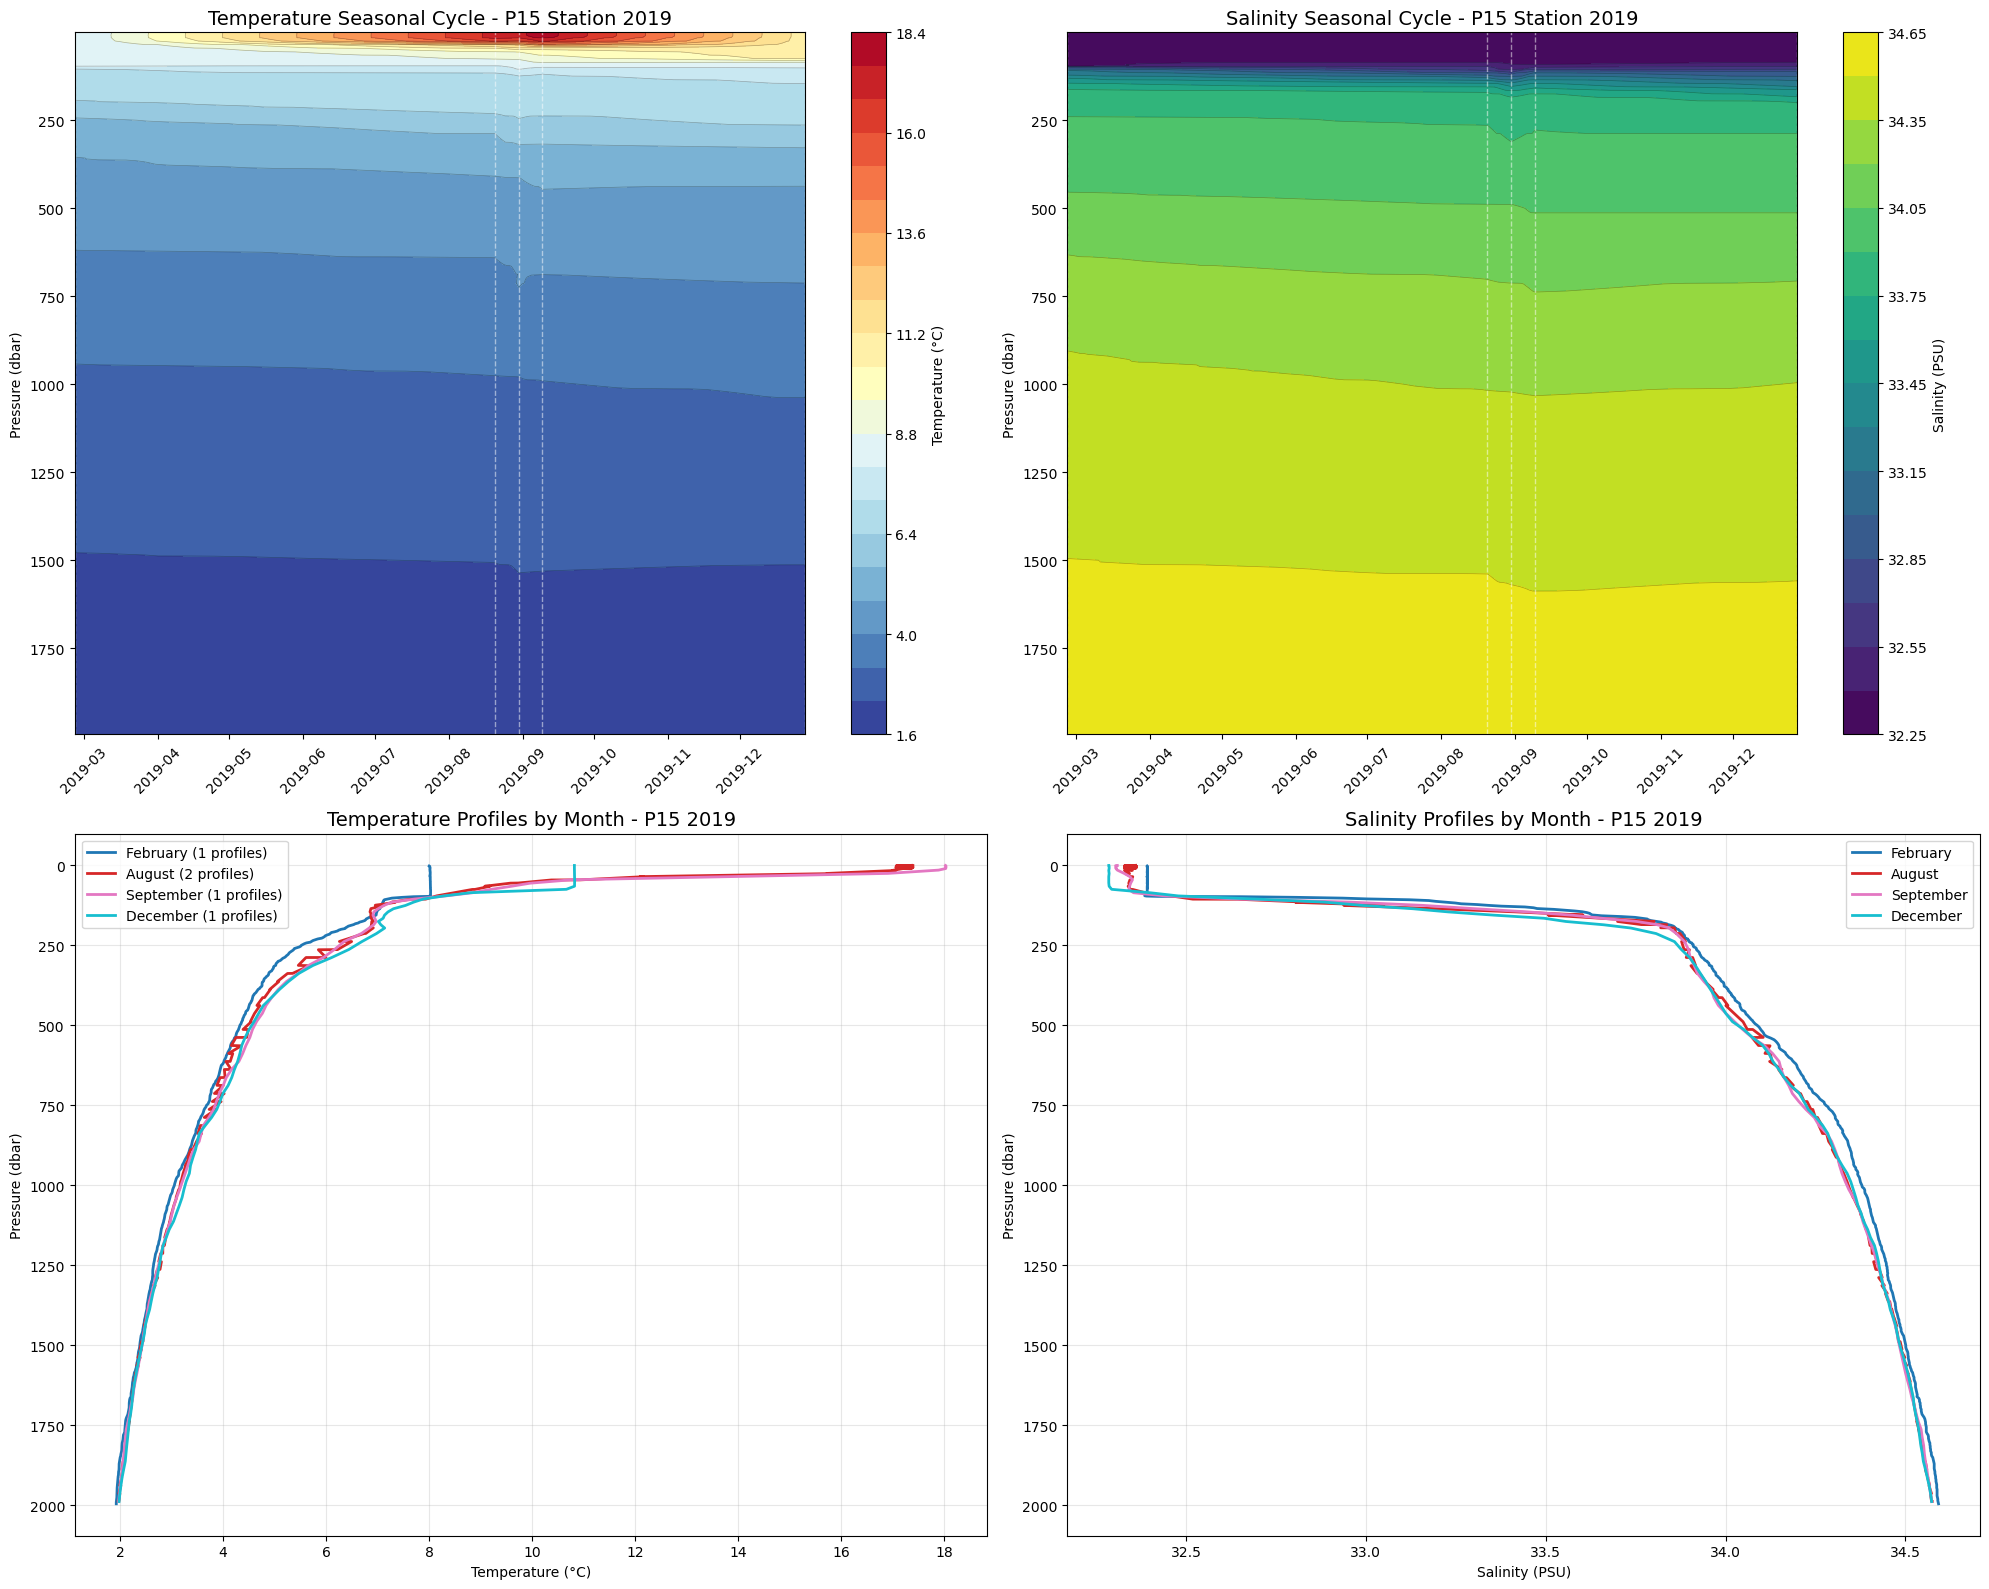


=== P15 2019 SEASONAL CYCLE ANALYSIS SUMMARY ===
Monthly Profile Summary:
                 profile_id  PRES               TEMP                    PSAL  \
                    nunique count          max  mean   min        max   mean   
month month_name                                                               
2     February            1   558  1995.000000  4.49  1.93   8.030000  33.91   
8     August              2   203  1987.599976  5.81  1.96  17.389999  33.84   
9     September           1   102  1987.900024  6.04  1.97  18.030001  33.84   
12    December            1   102  1987.900024  5.18  1.98  10.820000  33.82   

                                    
                        min    max  
month month_name                    
2     February    32.380001  34.59  
8     August      32.330002  34.57  
9     September   32.299999  34.57  
12    December    32.290001  34.57  

Surface Water Analysis (≤50m):
Temperature by month:
                 mean   std
month_name             

In [3]:
# Analyze any station and year
combined_profiles = analyze_station_seasonal_cycle(station_name, year)

Checking data by month:
  Month 2 (February): 558 measurements, 1 profile dates
  Month 8 (August): 203 measurements, 2 profile dates
  Month 9 (September): 102 measurements, 1 profile dates
  Month 12 (December): 102 measurements, 1 profile dates

Depth range: 0.4 to 1995.0 dbar
Months with data: ['February', 'August', 'September', 'December']


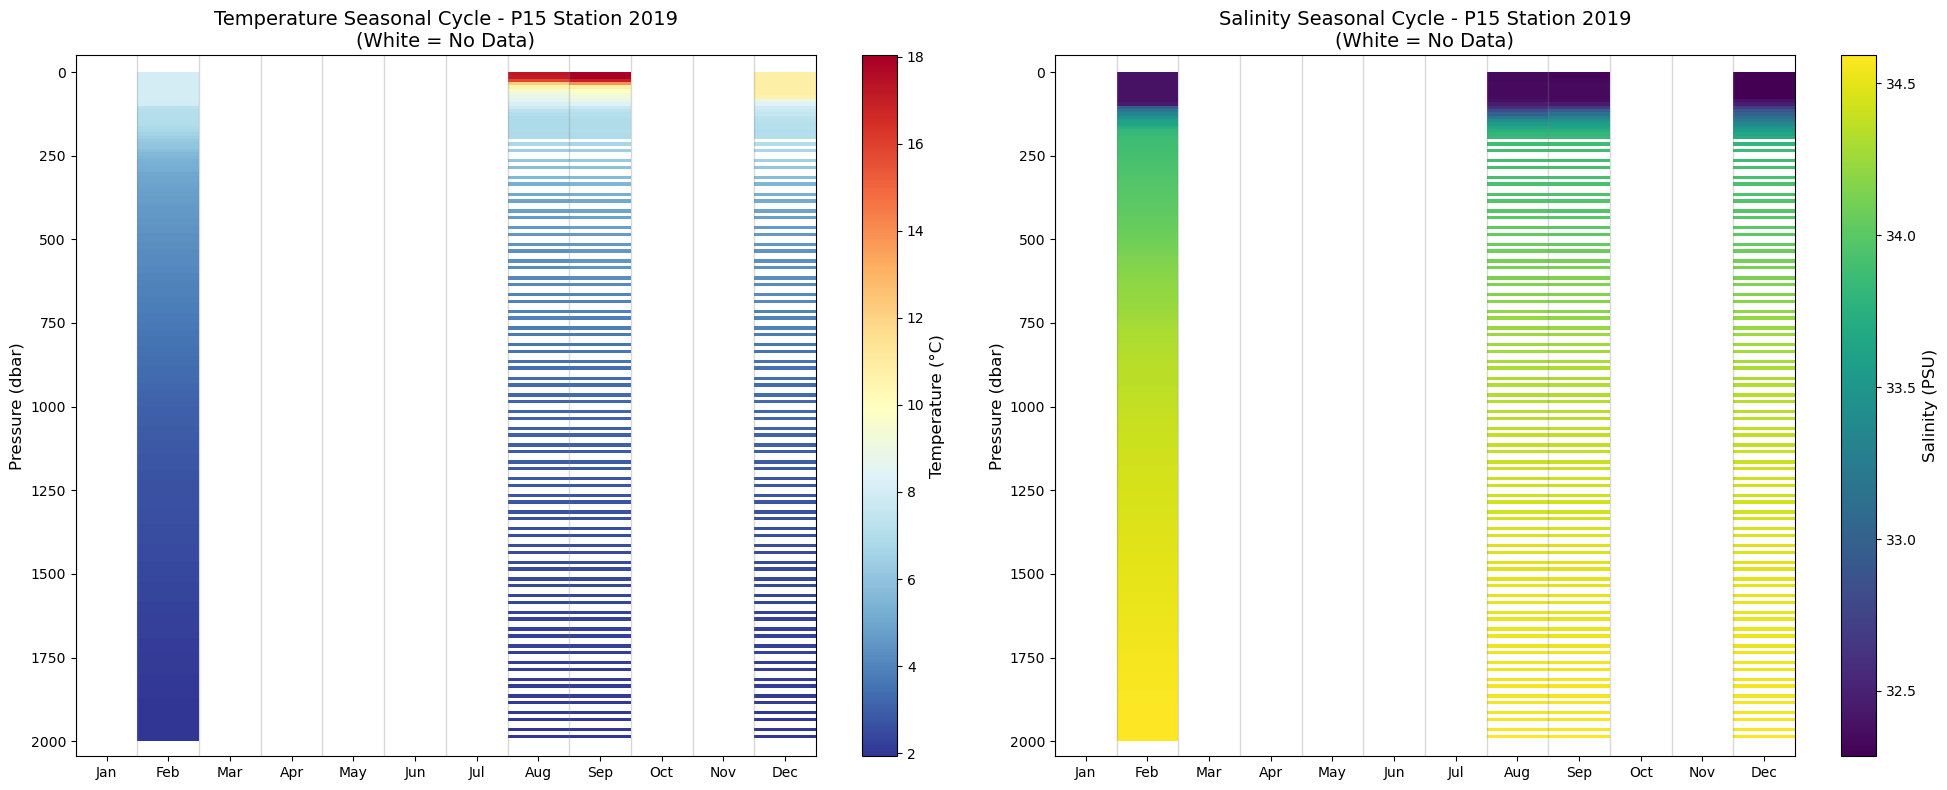

In [4]:

# Step 4: Create seasonal cycle plots - SIMPLE approach, no interpolation
fig, axes = plt.subplots(1, 2, figsize=(20, 8))  # Changed to 1 row, 2 columns

# Create a complete monthly time axis
import calendar

month_names = [calendar.month_abbr[i] for i in range(1, 13)]

print("Checking data by month:")
for month in sorted(combined_profiles['month'].unique()):
    month_data = combined_profiles[combined_profiles['month'] == month]
    dates = month_data['date_profile'].unique()
    print(f"  Month {month} ({calendar.month_name[month]}): {len(month_data)} measurements, {len(dates)} profile dates")

# Get actual depth range
max_pressure = combined_profiles['PRES'].max()
min_pressure = combined_profiles['PRES'].min()
print(f"\nDepth range: {min_pressure:.1f} to {max_pressure:.1f} dbar")

# Determine what parameters we have
temp_col = 'TEMP' if 'TEMP' in combined_profiles.columns else None
sal_col = 'PSAL' if 'PSAL' in combined_profiles.columns else None

# 4a. Temperature depth-time pcolor plot (showing all months, empty where no data)
if temp_col:
    months_with_data = sorted(combined_profiles['month'].unique())
    print(f"Months with data: {[calendar.month_name[m] for m in months_with_data]}")
    
    # Create pressure bins for binning the data
    pressure_bins = np.arange(0, max_pressure + 50, 10)  # 10 dbar bins
    pressure_centers = (pressure_bins[:-1] + pressure_bins[1:]) / 2
    
    # Create temperature matrix for ALL 12 months (will be NaN where no data)
    temp_matrix = np.full((len(pressure_bins)-1, 12), np.nan)
    
    # Fill only the months that have data
    for month in months_with_data:
        month_idx = month - 1  # Convert to 0-based index
        month_data = combined_profiles[combined_profiles['month'] == month]
        
        # Bin the data by pressure
        for j in range(len(pressure_bins)-1):
            bin_data = month_data[
                (month_data['PRES'] >= pressure_bins[j]) & 
                (month_data['PRES'] < pressure_bins[j+1])
            ]
            if len(bin_data) > 0:
                temp_matrix[j, month_idx] = bin_data[temp_col].mean()
    
    # Create mesh for pcolormesh - ALL 12 months
    month_indices = np.arange(12)  # 0-11 for all months
    X, Y = np.meshgrid(month_indices, pressure_centers)
    
    # Create pcolormesh - NaN values will appear as white/empty
    pcm = axes[0].pcolormesh(X, Y, temp_matrix, cmap='RdYlBu_r', shading='nearest')
    
    # Add colorbar
    cbar1 = plt.colorbar(pcm, ax=axes[0])
    cbar1.set_label('Temperature (°C)', fontsize=12)
    
    # Set up the plot - show ALL 12 months
    month_names = [calendar.month_abbr[i] for i in range(1, 13)]
    axes[0].set_xticks(month_indices)
    axes[0].set_xticklabels(month_names)
    axes[0].set_ylabel('Pressure (dbar)', fontsize=12)
    axes[0].set_title(f'Temperature Seasonal Cycle - {station_name} Station {year}\n(White = No Data)', fontsize=14)
    axes[0].invert_yaxis()
    axes[0].set_ylim(max_pressure + 50, -50)
    
    # Add vertical grid lines between months
    for i in range(12):
        axes[0].axvline(x=i-0.5, color='gray', alpha=0.3, linewidth=1)

# 4b. Salinity depth-time pcolor plot (showing all months, empty where no data)
if sal_col:
    # Same approach for salinity - ALL 12 months
    sal_matrix = np.full((len(pressure_bins)-1, 12), np.nan)
    
    # Fill only the months that have data
    for month in months_with_data:
        month_idx = month - 1  # Convert to 0-based index
        month_data = combined_profiles[combined_profiles['month'] == month]
        
        # Bin the data by pressure
        for j in range(len(pressure_bins)-1):
            bin_data = month_data[
                (month_data['PRES'] >= pressure_bins[j]) & 
                (month_data['PRES'] < pressure_bins[j+1])
            ]
            if len(bin_data) > 0:
                sal_matrix[j, month_idx] = bin_data[sal_col].mean()
    
    X, Y = np.meshgrid(month_indices, pressure_centers)
    
    # Create pcolormesh - NaN values will appear as white/empty
    pcm2 = axes[1].pcolormesh(X, Y, sal_matrix, cmap='viridis', shading='nearest')
    
    cbar2 = plt.colorbar(pcm2, ax=axes[1])
    cbar2.set_label('Salinity (PSU)', fontsize=12)
    
    axes[1].set_xticks(month_indices)
    axes[1].set_xticklabels(month_names)
    axes[1].set_ylabel('Pressure (dbar)', fontsize=12)
    axes[1].set_title(f'Salinity Seasonal Cycle - {station_name} Station {year}\n(White = No Data)', fontsize=14)
    axes[1].invert_yaxis()
    axes[1].set_ylim(max_pressure + 50, -50)
    
    # Add vertical grid lines between months
    for i in range(12):
        axes[1].axvline(x=i-0.5, color='gray', alpha=0.3, linewidth=1)

plt.tight_layout()
plt.savefig(f'{station_name}_{year}_seasonal_cycle_simple.png', dpi=300, bbox_inches='tight')
plt.show()

=== LOADING LINE P CTD DATA FOR 2016 ===

CTD data loaded: 205325 measurements
Columns: ['time', 'file', 'CTDPRS_DBAR', 'CTDTMP_ITS90_DEG_C', 'SALINITY_PSS78', 'latitude', 'longitude', 'OXYGEN_MMOL_M3', 'OXYGEN_UMOL_KG', 'closest_linep_station_name', 'distance_to_closest_station_km', 'PRS_bin_cntr']

✓ Found 'closest_linep_station_name' column
Available stations: ['P1', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P2', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P3', 'P35', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9']

Found 3993 CTD measurements at P15
CTD depth range: 3.0 - 2006.0 dbar
CTD temperature range: 1.94 - 17.22 °C
CTD salinity range: 32.32 - 34.59 PSU

Months with P15 CTD data: June, August

P15 CTD Monthly Summary:
                    file    time CTDPRS_DBAR        
                 nunique nunique       count     max
month month_name                                    
6     June             1       1        2000  2006.0
8     August           1   

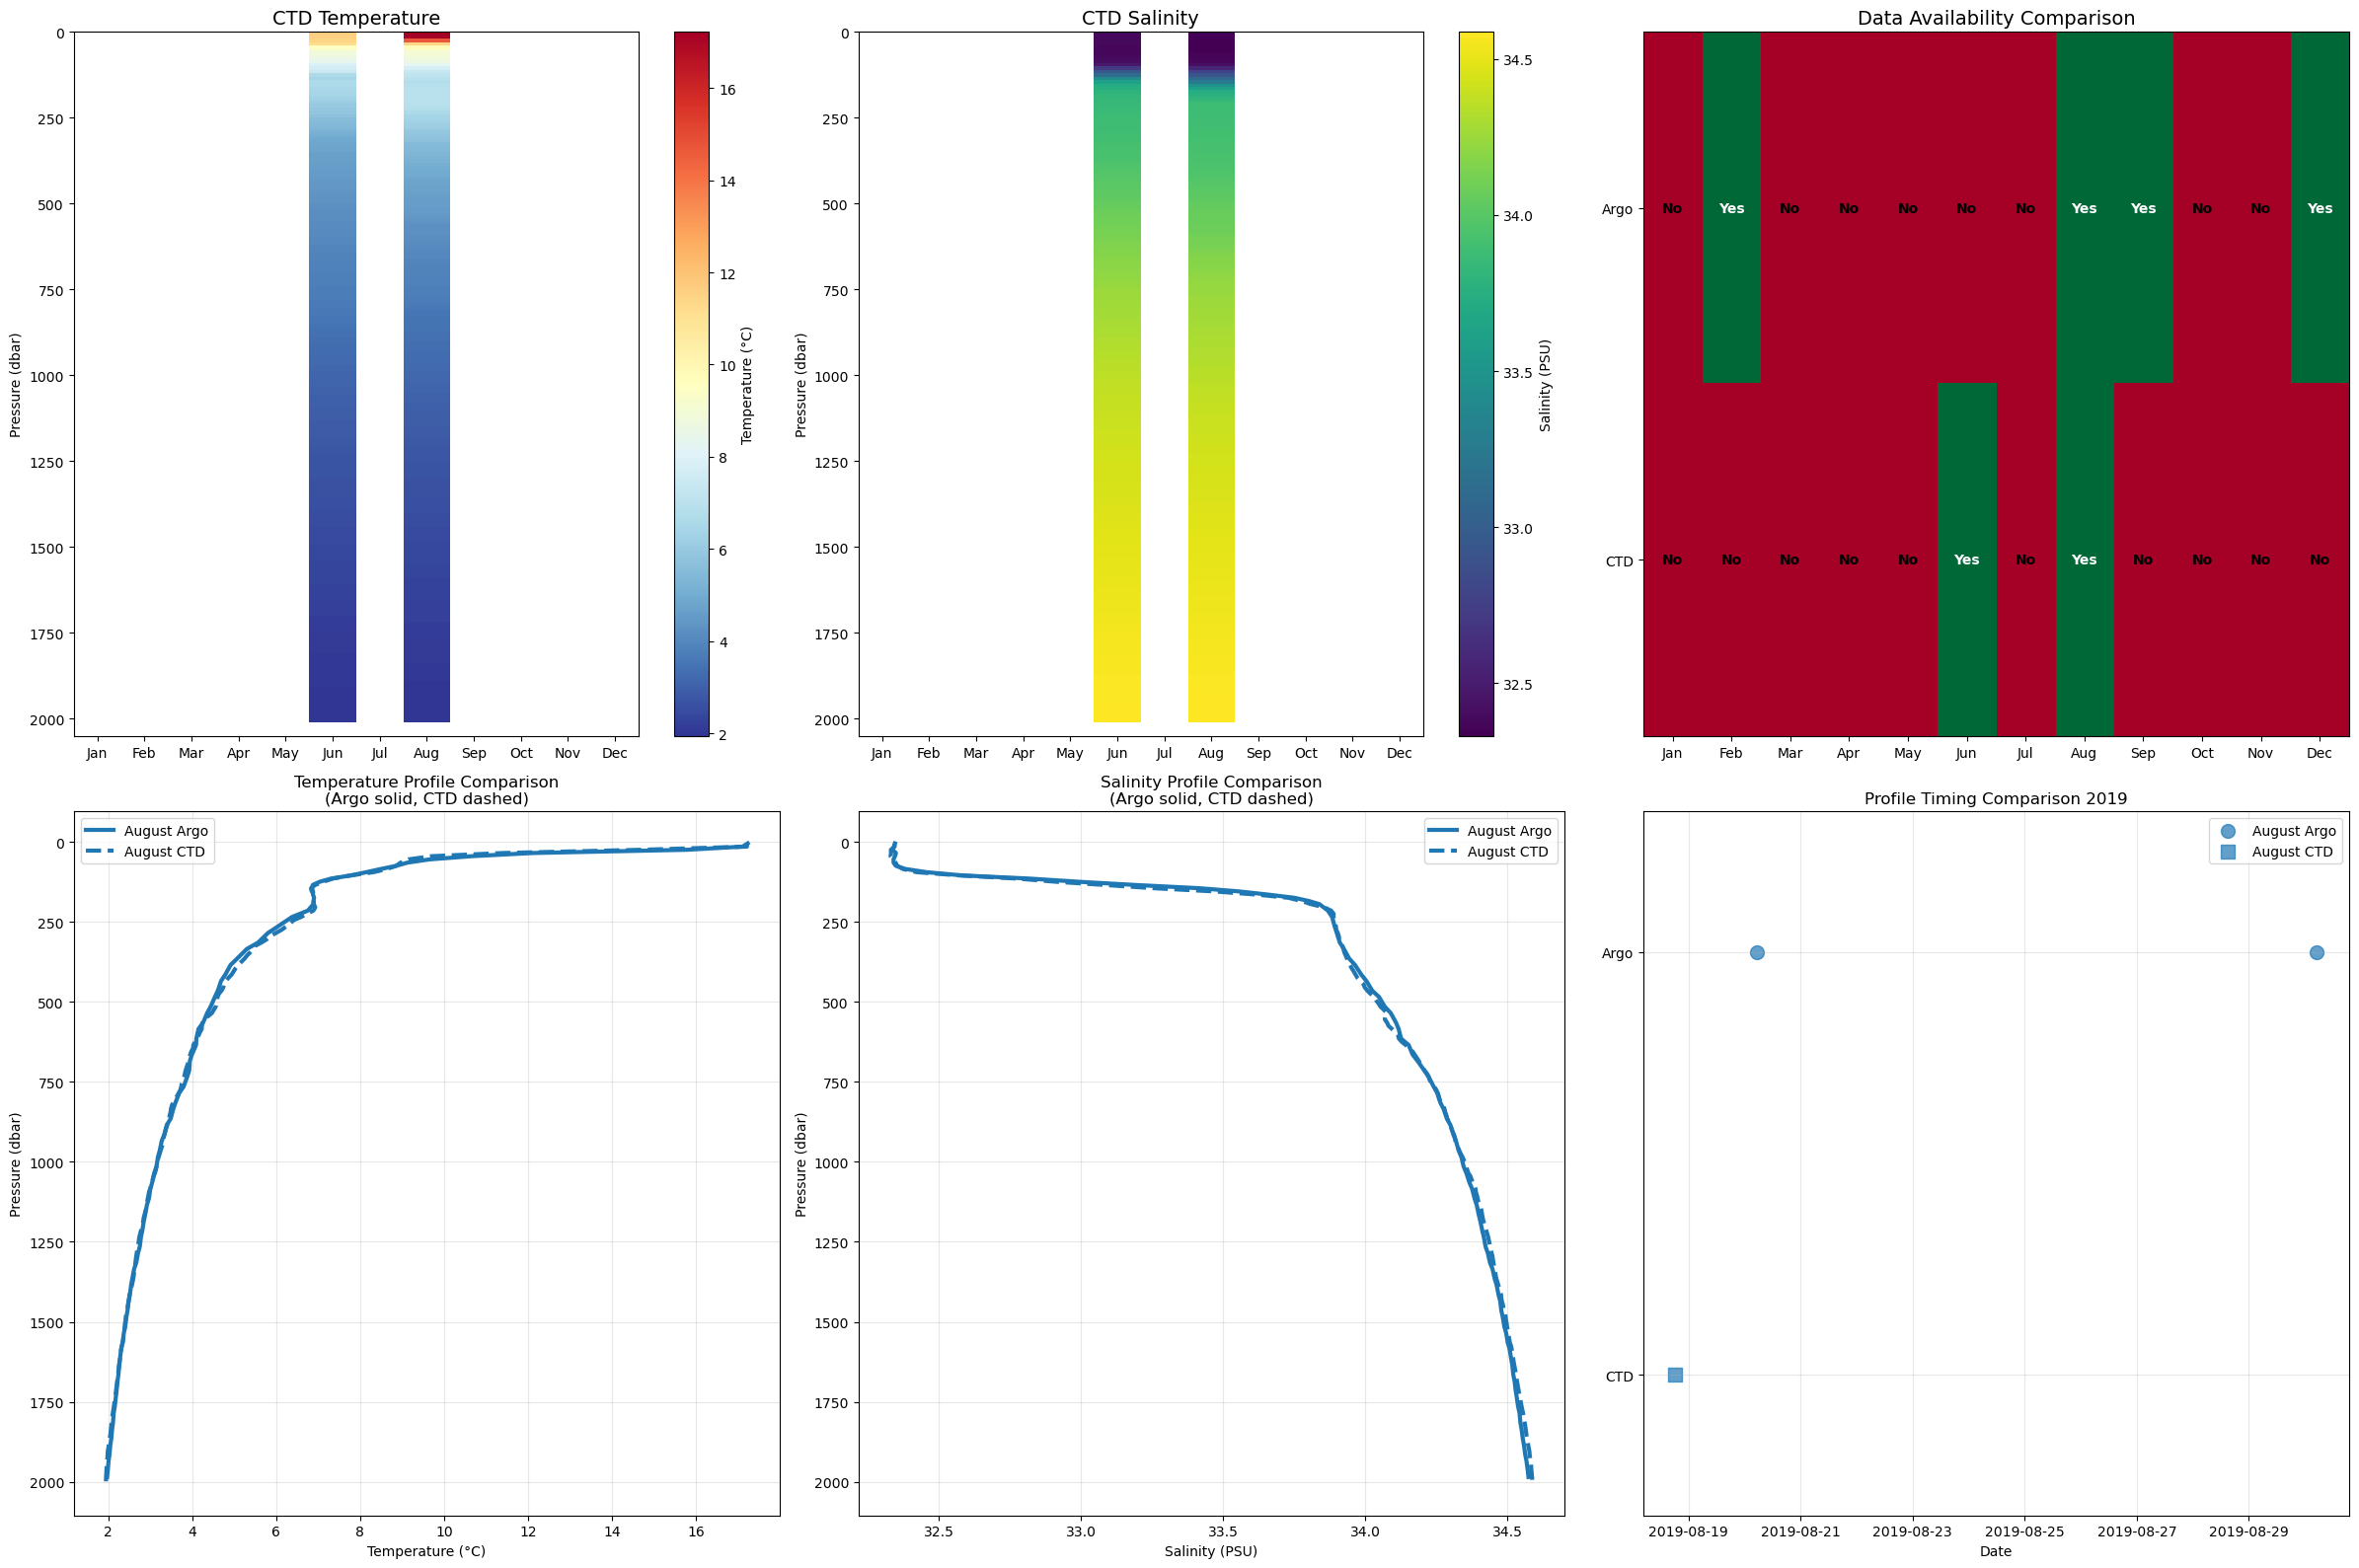


CTD data saved to 'P15_2019_CTD_data.csv'


In [5]:
# Load and analyze Line P CTD data for 2019 using station names
print("=== LOADING LINE P CTD DATA FOR 2016 ===\n")

# Load the CTD data
ctd_data = pd.read_csv(f'/gpfs/fs7/dfo/hpcmc/pfm/amh001/DATA/SD-Ocean/Training/observations/binned/LineP_ctds_{year}_binned_1m.csv')

print(f"CTD data loaded: {len(ctd_data)} measurements")
print("Columns:", ctd_data.columns.tolist())

# Check if the column exists
if 'closest_linep_station_name' in ctd_data.columns:
    print("\n✓ Found 'closest_linep_station_name' column")
    
    # Convert time to datetime
    ctd_data['time'] = pd.to_datetime(ctd_data['time'])
    ctd_data['month'] = ctd_data['time'].dt.month
    ctd_data['month_name'] = ctd_data['time'].dt.month_name()
    
    # Check what station names are available
    unique_stations = ctd_data['closest_linep_station_name'].unique()
    print(f"Available stations: {sorted([s for s in unique_stations if pd.notna(s)])}")
    
    # Filter for P15 station
    p15_ctd_data = ctd_data[ctd_data['closest_linep_station_name'] == station_name].copy()
    
    print(f"\nFound {len(p15_ctd_data)} CTD measurements at {station_name}")
    
    if len(p15_ctd_data) > 0:
        print(f"CTD depth range: {p15_ctd_data['CTDPRS_DBAR'].min():.1f} - {p15_ctd_data['CTDPRS_DBAR'].max():.1f} dbar")
        print(f"CTD temperature range: {p15_ctd_data['CTDTMP_ITS90_DEG_C'].min():.2f} - {p15_ctd_data['CTDTMP_ITS90_DEG_C'].max():.2f} °C")
        print(f"CTD salinity range: {p15_ctd_data['SALINITY_PSS78'].min():.2f} - {p15_ctd_data['SALINITY_PSS78'].max():.2f} PSU")
        
        # Check which months have CTD data
        ctd_months = sorted(p15_ctd_data['month'].unique())
        ctd_month_names = [calendar.month_name[m] for m in ctd_months]
        print(f"\nMonths with P15 CTD data: {', '.join(ctd_month_names)}")
        
        # Count profiles/casts by month
        ctd_monthly_summary = p15_ctd_data.groupby(['month', 'month_name']).agg({
            'file': 'nunique',  # number of different files/casts
            'time': 'nunique',  # number of different times
            'CTDPRS_DBAR': ['count', 'max']
        }).round(2)
        
        print("\nP15 CTD Monthly Summary:")
        print(ctd_monthly_summary)
        
        # Compare with Argo months
        if 'months_with_data' in locals():
            argo_months = set(months_with_data)
            ctd_months_set = set(ctd_months)
            
            print(f"\n=== COMPARISON: ARGO vs CTD COVERAGE ===")
            print(f"Argo months: {sorted(argo_months)} ({[calendar.month_abbr[m] for m in sorted(argo_months)]})")
            print(f"CTD months:  {sorted(ctd_months_set)} ({[calendar.month_abbr[m] for m in sorted(ctd_months_set)]})")
            
            overlap = argo_months.intersection(ctd_months_set)
            argo_only = argo_months - ctd_months_set
            ctd_only = ctd_months_set - argo_months
            
            print(f"Both Argo & CTD: {sorted(overlap)} ({[calendar.month_abbr[m] for m in sorted(overlap)]})")
            print(f"Argo only: {sorted(argo_only)} ({[calendar.month_abbr[m] for m in sorted(argo_only)]})")
            print(f"CTD only: {sorted(ctd_only)} ({[calendar.month_abbr[m] for m in sorted(ctd_only)]})")
            
            # Create comparison plots
            fig, axes = plt.subplots(2, 3, figsize=(24, 16))
            
            # 1. CTD Temperature depth-time plot
            pressure_bins = np.arange(0, p15_ctd_data['CTDPRS_DBAR'].max() + 50, 10)
            pressure_centers = (pressure_bins[:-1] + pressure_bins[1:]) / 2
            
            # Create temperature matrix for ALL 12 months
            ctd_temp_matrix = np.full((len(pressure_bins)-1, 12), np.nan)
            
            for month in ctd_months:
                month_idx = month - 1
                month_data = p15_ctd_data[p15_ctd_data['month'] == month]
                
                # Bin the data by pressure
                for j in range(len(pressure_bins)-1):
                    bin_data = month_data[
                        (month_data['CTDPRS_DBAR'] >= pressure_bins[j]) & 
                        (month_data['CTDPRS_DBAR'] < pressure_bins[j+1])
                    ]
                    if len(bin_data) > 0:
                        ctd_temp_matrix[j, month_idx] = bin_data['CTDTMP_ITS90_DEG_C'].mean()
            
            # Plot CTD temperature
            month_indices = np.arange(12)
            X, Y = np.meshgrid(month_indices, pressure_centers)
            
            pcm1 = axes[0,0].pcolormesh(X, Y, ctd_temp_matrix, cmap='RdYlBu_r', shading='nearest')
            cbar1 = plt.colorbar(pcm1, ax=axes[0,0])
            cbar1.set_label('Temperature (°C)')
            
            axes[0,0].set_xticks(month_indices)
            axes[0,0].set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)])
            axes[0,0].set_ylabel('Pressure (dbar)')
            axes[0,0].set_title('CTD Temperature', fontsize=14)
            axes[0,0].invert_yaxis()
            
            # 2. CTD Salinity depth-time plot
            ctd_sal_matrix = np.full((len(pressure_bins)-1, 12), np.nan)
            
            for month in ctd_months:
                month_idx = month - 1
                month_data = p15_ctd_data[p15_ctd_data['month'] == month]
                
                for j in range(len(pressure_bins)-1):
                    bin_data = month_data[
                        (month_data['CTDPRS_DBAR'] >= pressure_bins[j]) & 
                        (month_data['CTDPRS_DBAR'] < pressure_bins[j+1])
                    ]
                    if len(bin_data) > 0:
                        ctd_sal_matrix[j, month_idx] = bin_data['SALINITY_PSS78'].mean()
            
            pcm2 = axes[0,1].pcolormesh(X, Y, ctd_sal_matrix, cmap='viridis', shading='nearest')
            cbar2 = plt.colorbar(pcm2, ax=axes[0,1])
            cbar2.set_label('Salinity (PSU)')
            
            axes[0,1].set_xticks(month_indices)
            axes[0,1].set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)])
            axes[0,1].set_ylabel('Pressure (dbar)')
            axes[0,1].set_title('CTD Salinity', fontsize=14)
            axes[0,1].invert_yaxis()
            
            # 3. Data availability comparison
            coverage_matrix = np.zeros((2, 12))  # 2 rows: Argo, CTD
            
            for month in months_with_data:
                coverage_matrix[0, month-1] = 1  # Argo
            
            for month in ctd_months:
                coverage_matrix[1, month-1] = 1  # CTD
            
            im = axes[0,2].imshow(coverage_matrix, cmap='RdYlGn', aspect='auto')
            axes[0,2].set_xticks(month_indices)
            axes[0,2].set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)])
            axes[0,2].set_yticks([0, 1])
            axes[0,2].set_yticklabels(['Argo', 'CTD'])
            axes[0,2].set_title('Data Availability Comparison', fontsize=14)
            
            # Add text annotations
            for i in range(12):
                for j in range(2):
                    text = 'Yes' if coverage_matrix[j, i] == 1 else 'No'
                    color = 'white' if coverage_matrix[j, i] == 1 else 'black'
                    axes[0,2].text(i, j, text, ha='center', va='center', color=color, fontweight='bold')
            
            # Profile comparisons for overlapping months
            if overlap:
                colors_comparison = plt.cm.tab10(np.linspace(0, 1, len(overlap)))
                
                # 4. Temperature profile comparison
                for i, month in enumerate(sorted(overlap)):
                    month_name = calendar.month_name[month]
                    
                    # Argo data for this month
                    if 'combined_profiles' in locals():
                        argo_month = combined_profiles[combined_profiles['month'] == month]
                        if len(argo_month) > 0:
                            argo_temp_profile = []
                            argo_pres_profile = []
                            for j in range(len(pressure_bins)-1):
                                bin_data = argo_month[
                                    (argo_month['PRES'] >= pressure_bins[j]) & 
                                    (argo_month['PRES'] < pressure_bins[j+1])
                                ]
                                if len(bin_data) > 0:
                                    argo_temp_profile.append(bin_data['TEMP'].mean())
                                    argo_pres_profile.append((pressure_bins[j] + pressure_bins[j+1]) / 2)
                            
                            axes[1,0].plot(argo_temp_profile, argo_pres_profile, 
                                          color=colors_comparison[i], linewidth=3, 
                                          label=f'{month_name} Argo', linestyle='-')
                    
                    # CTD data for this month
                    ctd_month = p15_ctd_data[p15_ctd_data['month'] == month]
                    ctd_temp_profile = []
                    ctd_pres_profile = []
                    for j in range(len(pressure_bins)-1):
                        bin_data = ctd_month[
                            (ctd_month['CTDPRS_DBAR'] >= pressure_bins[j]) & 
                            (ctd_month['CTDPRS_DBAR'] < pressure_bins[j+1])
                        ]
                        if len(bin_data) > 0:
                            ctd_temp_profile.append(bin_data['CTDTMP_ITS90_DEG_C'].mean())
                            ctd_pres_profile.append((pressure_bins[j] + pressure_bins[j+1]) / 2)
                    
                    axes[1,0].plot(ctd_temp_profile, ctd_pres_profile, 
                                  color=colors_comparison[i], linewidth=3, 
                                  label=f'{month_name} CTD', linestyle='--')
                
                axes[1,0].set_xlabel('Temperature (°C)')
                axes[1,0].set_ylabel('Pressure (dbar)')
                axes[1,0].set_title('Temperature Profile Comparison\n(Argo solid, CTD dashed)')
                axes[1,0].invert_yaxis()
                axes[1,0].legend()
                axes[1,0].grid(True, alpha=0.3)
                
                # 5. Salinity profile comparison
                for i, month in enumerate(sorted(overlap)):
                    month_name = calendar.month_name[month]
                    
                    # Argo salinity
                    if 'combined_profiles' in locals():
                        argo_month = combined_profiles[combined_profiles['month'] == month]
                        if len(argo_month) > 0 and 'PSAL' in argo_month.columns:
                            argo_sal_profile = []
                            argo_pres_profile = []
                            for j in range(len(pressure_bins)-1):
                                bin_data = argo_month[
                                    (argo_month['PRES'] >= pressure_bins[j]) & 
                                    (argo_month['PRES'] < pressure_bins[j+1])
                                ]
                                if len(bin_data) > 0:
                                    argo_sal_profile.append(bin_data['PSAL'].mean())
                                    argo_pres_profile.append((pressure_bins[j] + pressure_bins[j+1]) / 2)
                            
                            axes[1,1].plot(argo_sal_profile, argo_pres_profile, 
                                          color=colors_comparison[i], linewidth=3, 
                                          label=f'{month_name} Argo', linestyle='-')
                    
                    # CTD salinity
                    ctd_month = p15_ctd_data[p15_ctd_data['month'] == month]
                    ctd_sal_profile = []
                    ctd_pres_profile = []
                    for j in range(len(pressure_bins)-1):
                        bin_data = ctd_month[
                            (ctd_month['CTDPRS_DBAR'] >= pressure_bins[j]) & 
                            (ctd_month['CTDPRS_DBAR'] < pressure_bins[j+1])
                        ]
                        if len(bin_data) > 0:
                            ctd_sal_profile.append(bin_data['SALINITY_PSS78'].mean())
                            ctd_pres_profile.append((pressure_bins[j] + pressure_bins[j+1]) / 2)
                    
                    axes[1,1].plot(ctd_sal_profile, ctd_pres_profile, 
                                  color=colors_comparison[i], linewidth=3, 
                                  label=f'{month_name} CTD', linestyle='--')
                
                axes[1,1].set_xlabel('Salinity (PSU)')
                axes[1,1].set_ylabel('Pressure (dbar)')
                axes[1,1].set_title('Salinity Profile Comparison\n(Argo solid, CTD dashed)')
                axes[1,1].invert_yaxis()
                axes[1,1].legend()
                axes[1,1].grid(True, alpha=0.3)
                
                # 6. Temporal distribution comparison
                for i, month in enumerate(sorted(overlap)):
                    # Argo profile dates
                    argo_dates = combined_profiles[combined_profiles['month'] == month]['date_profile'].unique()
                    # CTD profile dates  
                    ctd_dates = p15_ctd_data[p15_ctd_data['month'] == month]['time'].unique()
                    
                    # Plot as timeline
                    y_argo = [0.8] * len(argo_dates)
                    y_ctd = [0.2] * len(ctd_dates)
                    
                    axes[1,2].scatter(argo_dates, y_argo, color=colors_comparison[i], 
                                    s=100, marker='o', label=f'{calendar.month_name[month]} Argo', alpha=0.7)
                    axes[1,2].scatter(ctd_dates, y_ctd, color=colors_comparison[i], 
                                    s=100, marker='s', label=f'{calendar.month_name[month]} CTD', alpha=0.7)
                
                axes[1,2].set_ylim(0, 1)
                axes[1,2].set_yticks([0.2, 0.8])
                axes[1,2].set_yticklabels(['CTD', 'Argo'])
                axes[1,2].set_xlabel('Date')
                axes[1,2].set_title('Profile Timing Comparison 2019')
                axes[1,2].legend()
                axes[1,2].grid(True, alpha=0.3)
            
            plt.tight_layout()
           # plt.savefig('P15_2019_Argo_vs_CTD_comparison.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            # Save data
            #p15_ctd_data.to_csv('P15_2019_CTD_data.csv', index=False)
            print(f"\nCTD data saved to 'P15_2019_CTD_data.csv'")
            
    else:
        print("No CTD data found for P15 station")
        print("Available stations with data:")
        station_counts = ctd_data['closest_linep_station_name'].value_counts()
        print(station_counts.head(10))

else:
    print("❌ Column 'closest_linep_station_name' not found")
    print("Let's check what columns might contain station information:")
    potential_cols = [col for col in ctd_data.columns if any(word in col.lower() for word in ['station', 'name', 'site', 'location'])]
    print(f"Potential station columns: {potential_cols}")
    
    if potential_cols:
        for col in potential_cols:
            print(f"\n{col}: {ctd_data[col].unique()[:10]}")

 # The argo floats and ctds amatch where they overlap. Let's combine them together

In [6]:
# ===== STEP 1: BIN ARGO DATA USING SAME METHOD AS CTDs =====
print("=== BINNING ARGO DATA TO MATCH CTD 1M BINS ===\n")

# Check what Argo data we have
if 'combined_profiles' in locals() and len(combined_profiles) > 0:
    print(f"Starting with {len(combined_profiles)} Argo measurements")
    print(f"Argo depth range: {combined_profiles['PRES'].min():.1f} - {combined_profiles['PRES'].max():.1f} dbar")
    
    # Define binning parameters (same as CTDs)
    depth_column = 'PRES'  # Argo pressure column
    bin_width = 1  # 1m bins to match CTDs
    bin_edges = np.arange(0, 7000, bin_width)  # Same as CTD processing
    bin_centers = bin_edges[:-1] + bin_width/2
    
    print(f"Using {len(bin_centers)} bins from 0 to {bin_edges[-1]} dbar (1m bins)")
    
    # Create a copy of Argo data for binning
    argo_binned = combined_profiles.copy()
    
    # Assign each measurement to its bin (keep ALL rows, same as CTD processing)
    argo_binned['PRS_bin_cntr'] = pd.cut(argo_binned[depth_column], 
                                        bins=bin_edges, 
                                        labels=bin_centers, 
                                        right=False)
    
    # Check binning results
    print(f"Argo measurements after binning assignment: {len(argo_binned)}")
    print(f"Measurements with valid bin assignment: {argo_binned['PRS_bin_cntr'].notna().sum()}")
    print(f"Depth range of binned data: {argo_binned['PRS_bin_cntr'].min():.1f} - {argo_binned['PRS_bin_cntr'].max():.1f} dbar")
    
    # Show binning summary by month
    print(f"\nBinning summary by month:")
    binning_summary = argo_binned.groupby('month').agg({
        'PRS_bin_cntr': ['count', lambda x: x.notna().sum()],
        'profile_id': 'nunique',
        'PRES': ['min', 'max']
    }).round(1)
    binning_summary.columns = ['Total_Measurements', 'Successfully_Binned', 'Unique_Profiles', 'Min_Depth', 'Max_Depth']
    print(binning_summary)
    
    # Remove measurements that couldn't be binned (outside depth range)
    argo_binned = argo_binned.dropna(subset=['PRS_bin_cntr'])
    print(f"\nFinal Argo binned dataset: {len(argo_binned)} measurements")
    
    # Add some metadata
    argo_binned['data_source'] = 'Argo'
    argo_binned['bin_width'] = bin_width
    
    print(f"✓ Argo data binned successfully using 1m bins")
    
else:
    print("❌ No Argo data available. Please load Argo profiles first.")
    argo_binned = None

# ===== STEP 2: PREPARE CTD DATA IN SAME FORMAT =====
print(f"\n=== PREPARING CTD DATA WITH CONSISTENT FORMAT ===")

if 'p15_ctd_data' in locals() and len(p15_ctd_data) > 0:
    print(f"Starting with {len(p15_ctd_data)} CTD measurements")
    
    # Create a copy and add the binning column if it doesn't exist
    ctd_binned = p15_ctd_data.copy()
    
    # Check if CTD data already has bin centers or if we need to create them
    if 'PRS_bin_cntr' not in ctd_binned.columns:
        print("Adding bin centers to CTD data...")
        # Assume CTD data is already at 1m intervals, so use pressure as bin center
        ctd_binned['PRS_bin_cntr'] = ctd_binned['CTDPRS_DBAR'].round(0)  # Round to nearest meter
    
    # Add metadata to match Argo format
    ctd_binned['data_source'] = 'CTD'
    ctd_binned['bin_width'] = bin_width
    
    print(f"CTD depth range: {ctd_binned['CTDPRS_DBAR'].min():.1f} - {ctd_binned['CTDPRS_DBAR'].max():.1f} dbar")
    print(f"CTD bin centers range: {ctd_binned['PRS_bin_cntr'].min():.1f} - {ctd_binned['PRS_bin_cntr'].max():.1f} dbar")
    
    # Show CTD summary by month
    print(f"\nCTD summary by month:")
    ctd_monthly = ctd_binned.groupby('month').agg({
        'PRS_bin_cntr': 'count',
        'file': 'nunique',
        'CTDPRS_DBAR': ['min', 'max']
    }).round(1)
    ctd_monthly.columns = ['Total_Measurements', 'Unique_Files', 'Min_Depth', 'Max_Depth']
    print(ctd_monthly)
    
    print(f"✓ CTD data prepared with consistent binning")
    
else:
    print("❌ No CTD data available. Please load P15 CTD data first.")
    ctd_binned = None

# ===== STEP 3: VERIFY BOTH DATASETS ARE READY FOR COMBINATION =====
print(f"\n=== VERIFICATION OF BINNED DATASETS ===")

if argo_binned is not None and ctd_binned is not None:
    print("✓ Both datasets ready for combination")
    
    # Show common months
    argo_months = set(argo_binned['month'].unique())
    ctd_months = set(ctd_binned['month'].unique())
    
    print(f"\nMonth coverage:")
    print(f"Argo months: {sorted(argo_months)} ({[calendar.month_abbr[m] for m in sorted(argo_months)]})")
    print(f"CTD months: {sorted(ctd_months)} ({[calendar.month_abbr[m] for m in sorted(ctd_months)]})")
    
    overlap = argo_months.intersection(ctd_months)
    argo_only = argo_months - ctd_months
    ctd_only = ctd_months - argo_months
    
    print(f"Overlapping months: {sorted(overlap)} ({[calendar.month_abbr[m] for m in sorted(overlap)]})")
    print(f"Argo only: {sorted(argo_only)} ({[calendar.month_abbr[m] for m in sorted(argo_only)]})")
    print(f"CTD only: {sorted(ctd_only)} ({[calendar.month_abbr[m] for m in sorted(ctd_only)]})")
    
    # Check depth overlap
    argo_depth_range = (argo_binned['PRS_bin_cntr'].min(), argo_binned['PRS_bin_cntr'].max())
    ctd_depth_range = (ctd_binned['PRS_bin_cntr'].min(), ctd_binned['PRS_bin_cntr'].max())
    
    print(f"\nDepth coverage:")
    print(f"Argo: {argo_depth_range[0]:.0f} - {argo_depth_range[1]:.0f} dbar")
    print(f"CTD: {ctd_depth_range[0]:.0f} - {ctd_depth_range[1]:.0f} dbar")
    
    common_depth_min = max(argo_depth_range[0], ctd_depth_range[0])
    common_depth_max = min(argo_depth_range[1], ctd_depth_range[1])
    print(f"Common depth range: {common_depth_min:.0f} - {common_depth_max:.0f} dbar")
    
    # Show parameter availability
    print(f"\nParameter availability:")
    print(f"Argo - Temperature: {'TEMP' in argo_binned.columns}")
    print(f"Argo - Salinity: {'PSAL' in argo_binned.columns}")
    print(f"CTD - Temperature: {'CTDTMP_ITS90_DEG_C' in ctd_binned.columns}")
    print(f"CTD - Salinity: {'SALINITY_PSS78' in ctd_binned.columns}")
    
    print(f"\n=== READY FOR NEXT STEP: COMBINING THE DATASETS ===")
    print("Both datasets are now binned to 1m resolution and ready for combination.")
    
elif argo_binned is not None:
    print("⚠️  Only Argo data available - can proceed with Argo-only analysis")
    
elif ctd_binned is not None:
    print("⚠️  Only CTD data available - can proceed with CTD-only analysis")
    
else:
    print("❌ No data available for combination")

# Save the binned datasets
#if argo_binned is not None:
 #   argo_binned.to_csv('P15_2019_argo_1m_binned.csv', index=False)
  #  print(f"Argo binned data saved to: 'P15_2019_argo_1m_binned.csv'")

#if ctd_binned is not None:
 #   ctd_binned.to_csv('P15_2019_ctd_1m_binned.csv', index=False)
  #  print(f"CTD binned data saved to: 'P15_2019_ctd_1m_binned.csv'")

=== BINNING ARGO DATA TO MATCH CTD 1M BINS ===

Starting with 965 Argo measurements
Argo depth range: 0.4 - 1995.0 dbar
Using 6999 bins from 0 to 6999 dbar (1m bins)
Argo measurements after binning assignment: 965
Measurements with valid bin assignment: 965
Depth range of binned data: 0.5 - 1995.5 dbar

Binning summary by month:
       Total_Measurements  Successfully_Binned  Unique_Profiles  Min_Depth  \
month                                                                        
2                     558                  558                1        2.0   
8                     203                  203                2        0.4   
9                     102                  102                1        0.4   
12                    102                  102                1        0.4   

         Max_Depth  
month               
2      1995.000000  
8      1987.599976  
9      1987.900024  
12     1987.900024  

Final Argo binned dataset: 965 measurements
✓ Argo data binned successful

=== COMBINING BINNED DATASETS ===

Standardizing column names...
Combining datasets...
Combined dataset: 4958 measurements
- Argo: 965 measurements
- CTD: 3993 measurements

Creating monthly depth-bin averages...
Monthly averaged dataset: 4553 depth-month combinations
Months available: ['Feb', 'Jun', 'Aug', 'Sep', 'Dec']

Preparing data for visualization...
Plotting depth range: 0 to 2000 m
Using 2001 depth levels

Creating visualizations...


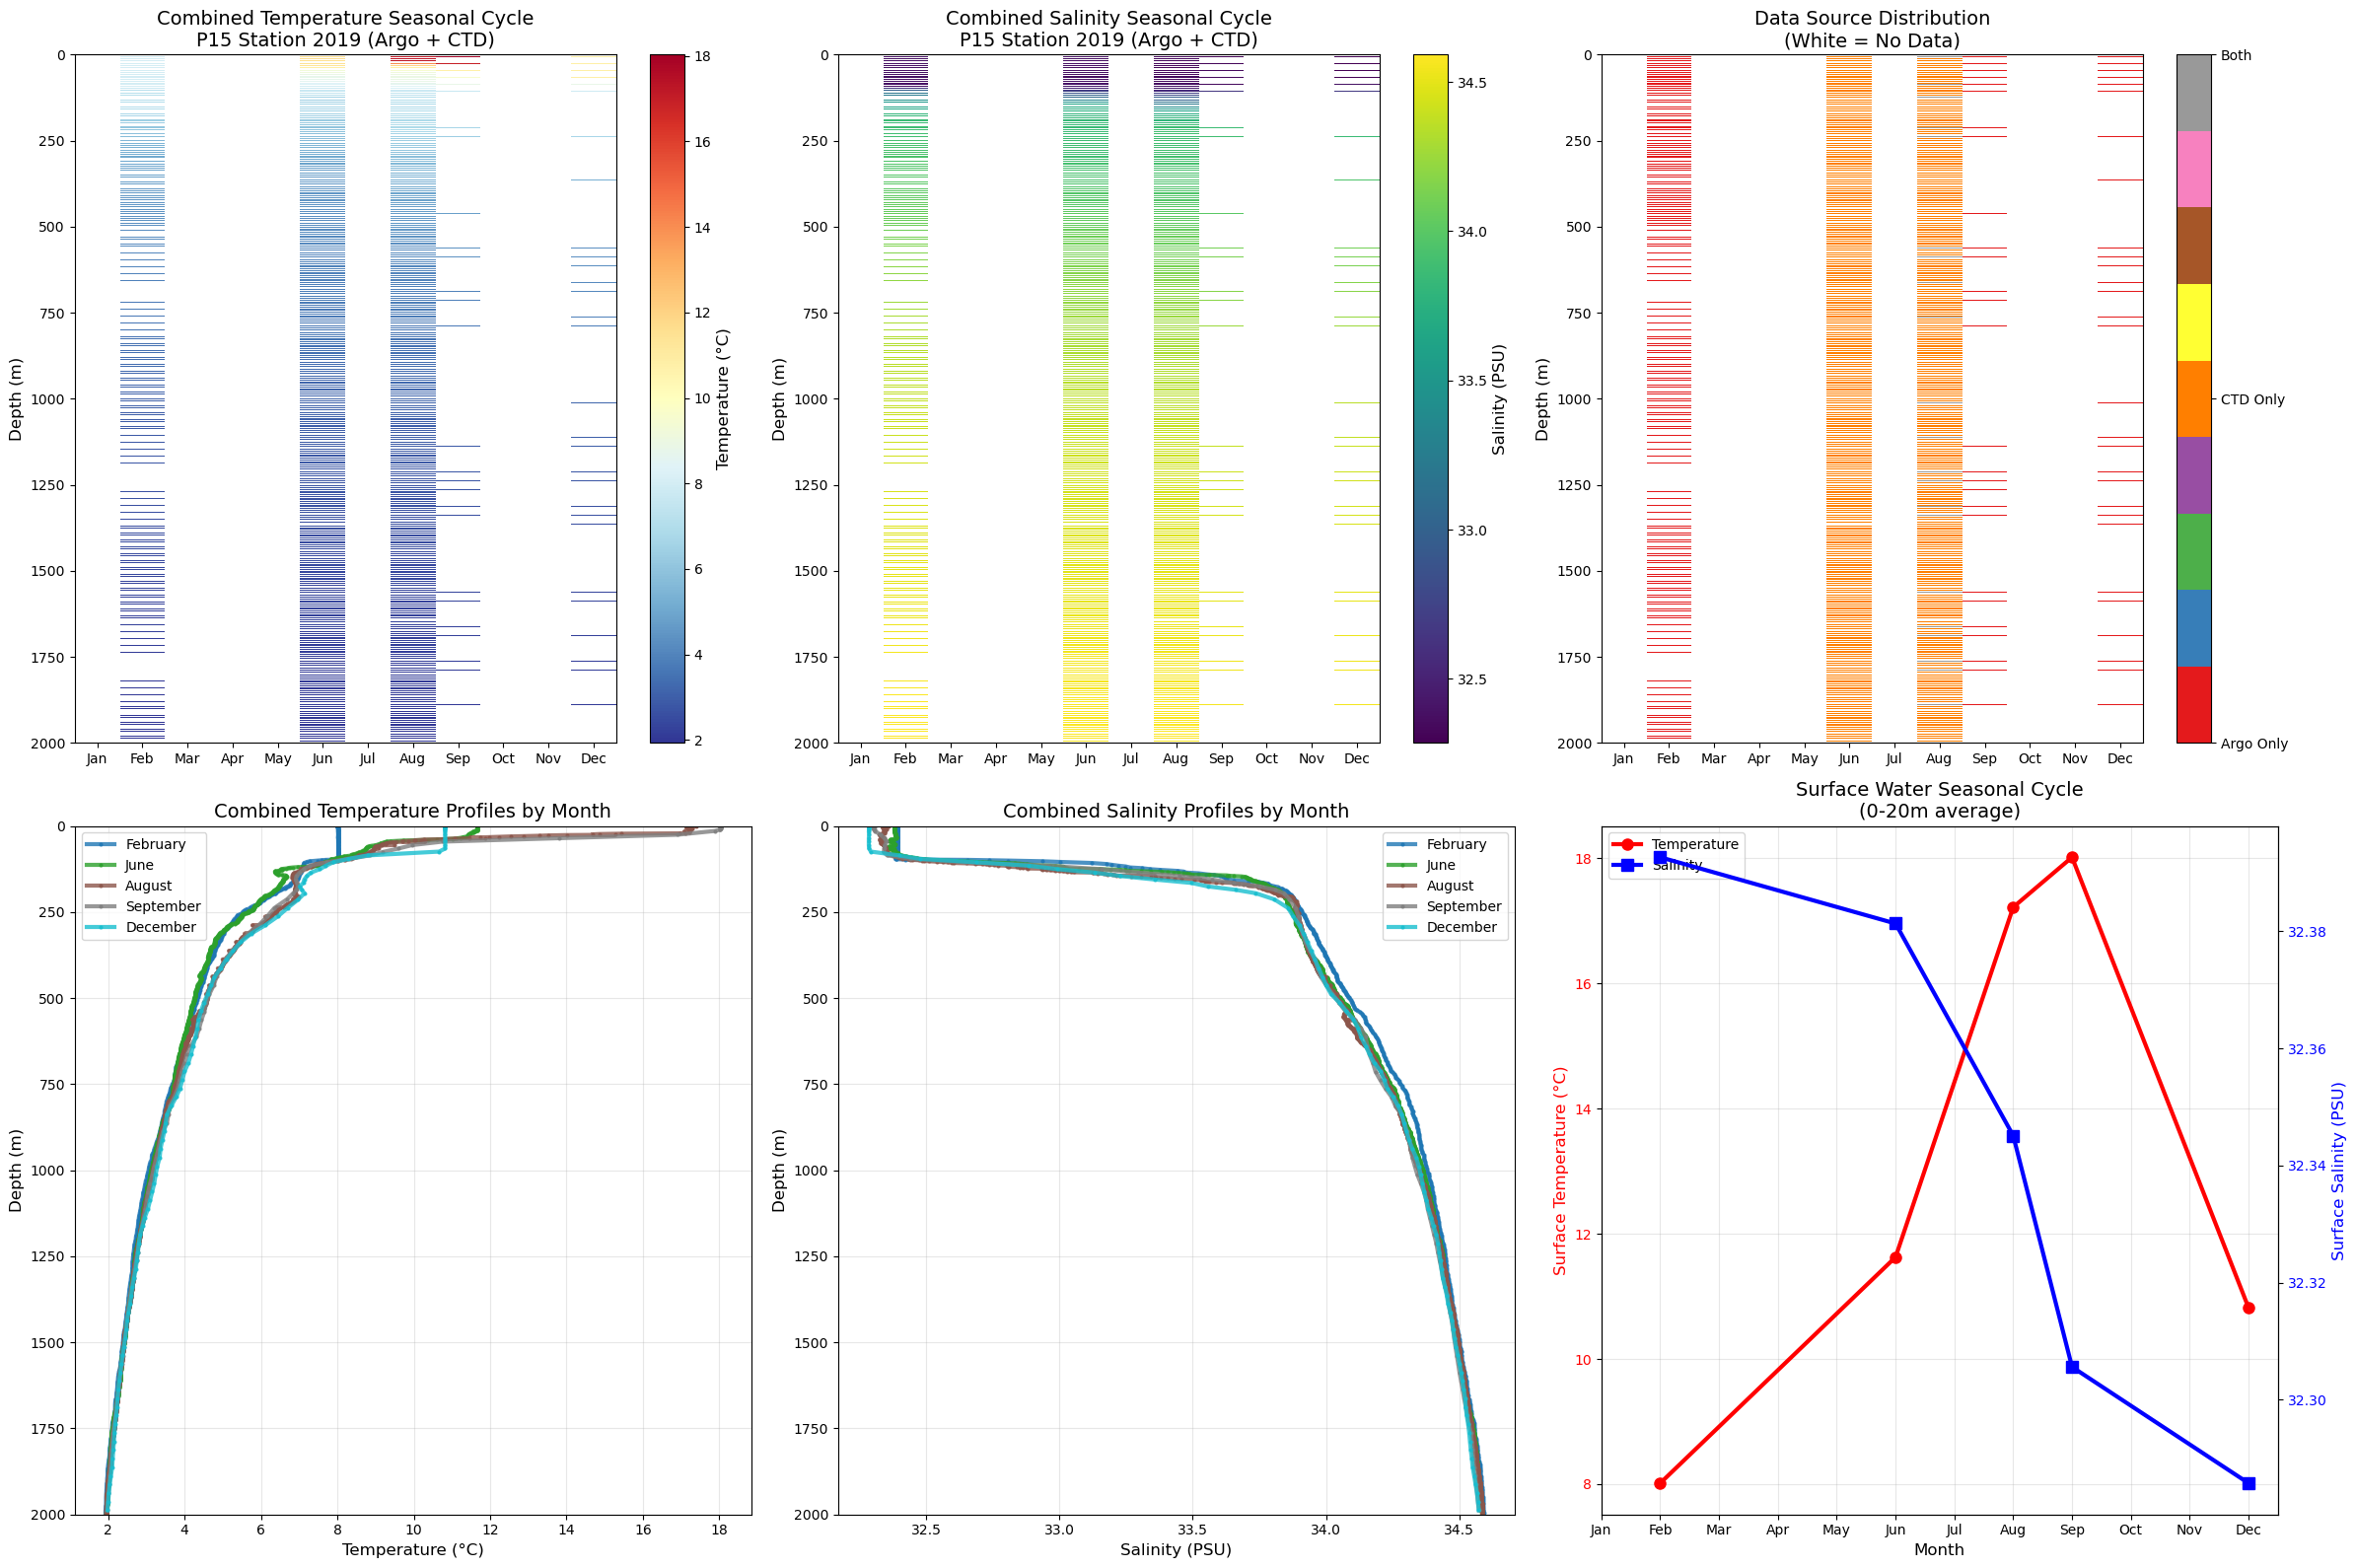


=== SAVING RESULTS ===
Combined raw data saved: 'P15_2019_combined_raw_1m.csv' (4958 measurements)
Monthly averages saved: 'P15_2019_combined_monthly_1m.csv' (4553 depth-month combinations)

=== FINAL SUMMARY ===
Total measurements combined: 4958
Depth range: 0 to 2000 m (plotted)
Months available: 5/12 (['Feb', 'Jun', 'Aug', 'Sep', 'Dec'])

Data source breakdown:
- CTD: 3993 measurements (80.5%)
- Argo: 965 measurements (19.5%)

Monthly coverage:
data_source  Argo  Argo+CTD   CTD
month                            
2             552         0     0
6               0         0  1902
8              10       131  1756
9             102         0     0
12            100         0     0

✓ Combined seasonal cycle complete!
The visualization shows the complete 2019 seasonal cycle at P15 station
using both Argo float and CTD observations at 1m vertical resolution.


In [7]:
# ===== COMBINING BINNED ARGO AND CTD DATA =====
print("=== COMBINING BINNED DATASETS ===\n")

if argo_binned is not None and ctd_binned is not None:
    
    # Step 1: Standardize column names for combination
    print("Standardizing column names...")
    
    # Create standardized Argo dataset
    argo_std = argo_binned[['month', 'month_name', 'PRS_bin_cntr', 'TEMP', 'PSAL', 'data_source', 'date_profile']].copy()
    argo_std = argo_std.rename(columns={
        'TEMP': 'temperature',
        'PSAL': 'salinity',
        'date_profile': 'date'
    })
    
    # Create standardized CTD dataset  
    ctd_std = ctd_binned[['month', 'month_name', 'PRS_bin_cntr', 'CTDTMP_ITS90_DEG_C', 'SALINITY_PSS78', 'data_source', 'time']].copy()
    ctd_std = ctd_std.rename(columns={
        'CTDTMP_ITS90_DEG_C': 'temperature',
        'SALINITY_PSS78': 'salinity',
        'time': 'date'
    })
    
    # Step 2: Combine the datasets
    print("Combining datasets...")
    combined_data = pd.concat([argo_std, ctd_std], ignore_index=True)
    
    print(f"Combined dataset: {len(combined_data)} measurements")
    print(f"- Argo: {len(argo_std)} measurements")
    print(f"- CTD: {len(ctd_std)} measurements")
    
    # Add some derived colum|ns
    combined_data['depth'] = combined_data['PRS_bin_cntr']  # Depth in meters (approximately)
    combined_data['year'] = 2019  # Since we're working with 2019 data
    
    # Step 3: Create monthly averages for each depth bin
    print("\nCreating monthly depth-bin averages...")
    
    monthly_binned_avg = combined_data.groupby(['month', 'month_name', 'depth']).agg({
        'temperature': 'mean',
        'salinity': 'mean',
        'data_source': lambda x: '+'.join(sorted(set(x))),  # Show which sources contributed
        'date': 'count'  # Number of measurements per bin
    }).reset_index()
    
    monthly_binned_avg = monthly_binned_avg.rename(columns={'date': 'n_measurements'})
    
    print(f"Monthly averaged dataset: {len(monthly_binned_avg)} depth-month combinations")
    
    # Check data coverage
    months_available = sorted(monthly_binned_avg['month'].unique())
    print(f"Months available: {[calendar.month_abbr[m] for m in months_available]}")
    
    # Step 4: Create matrices for plotting
    print("\nPreparing data for visualization...")
    
    # Get depth range that has good coverage
    depth_counts = monthly_binned_avg.groupby('depth')['month'].count()
    well_sampled_depths = depth_counts[depth_counts >= 2].index  # Depths sampled in at least 2 months
    
    max_plot_depth = min(2000, well_sampled_depths.max()) if len(well_sampled_depths) > 0 else 2000
    plot_depths = np.arange(0, max_plot_depth + 1, 1)  # 1m resolution
    
    print(f"Plotting depth range: 0 to {max_plot_depth} m")
    print(f"Using {len(plot_depths)} depth levels")
    
    # Create temperature and salinity matrices
    temp_matrix = np.full((len(plot_depths), 12), np.nan)
    sal_matrix = np.full((len(plot_depths), 12), np.nan)
    source_info = {}  # Track data sources
    
    for _, row in monthly_binned_avg.iterrows():
        month_idx = int(row['month']) - 1  # Convert to 0-based
        depth_val = row['depth']
        
        # Find closest depth index
        if 0 <= depth_val <= max_plot_depth:
            depth_idx = int(np.round(depth_val))
            if depth_idx < len(plot_depths):
                temp_matrix[depth_idx, month_idx] = row['temperature']
                sal_matrix[depth_idx, month_idx] = row['salinity']
                source_info[(depth_idx, month_idx)] = row['data_source']
    
    # Step 5: Create comprehensive visualization
    print("\nCreating visualizations...")
    
    fig, axes = plt.subplots(2, 3, figsize=(24, 16))
    
    # 1. Combined Temperature seasonal cycle
    month_indices = np.arange(12)
    X, Y = np.meshgrid(month_indices, plot_depths)
    
    pcm1 = axes[0,0].pcolormesh(X, Y, temp_matrix, cmap='RdYlBu_r', shading='nearest')
    cbar1 = plt.colorbar(pcm1, ax=axes[0,0])
    cbar1.set_label('Temperature (°C)', fontsize=12)
    
    axes[0,0].set_xticks(month_indices)
    axes[0,0].set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)])
    axes[0,0].set_ylabel('Depth (m)', fontsize=12)
    axes[0,0].set_title('Combined Temperature Seasonal Cycle\nP15 Station 2019 (Argo + CTD)', fontsize=14)
    axes[0,0].invert_yaxis()
    axes[0,0].set_ylim(max_plot_depth, 0)
    
    # 2. Combined Salinity seasonal cycle
    pcm2 = axes[0,1].pcolormesh(X, Y, sal_matrix, cmap='viridis', shading='nearest')
    cbar2 = plt.colorbar(pcm2, ax=axes[0,1])
    cbar2.set_label('Salinity (PSU)', fontsize=12)
    
    axes[0,1].set_xticks(month_indices)
    axes[0,1].set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)])
    axes[0,1].set_ylabel('Depth (m)', fontsize=12)
    axes[0,1].set_title('Combined Salinity Seasonal Cycle\nP15 Station 2019 (Argo + CTD)', fontsize=14)
    axes[0,1].invert_yaxis()
    axes[0,1].set_ylim(max_plot_depth, 0)
    
    # 3. Data source visualization
    source_matrix = np.zeros((len(plot_depths), 12))
    for (depth_idx, month_idx), source in source_info.items():
        if 'Argo+CTD' in source or 'CTD+Argo' in source:
            source_matrix[depth_idx, month_idx] = 3  # Both
        elif 'Argo' in source:
            source_matrix[depth_idx, month_idx] = 1  # Argo only
        elif 'CTD' in source:
            source_matrix[depth_idx, month_idx] = 2  # CTD only
    
    # Mask zeros to show as white
    source_matrix_masked = np.ma.masked_where(source_matrix == 0, source_matrix)
    
    pcm3 = axes[0,2].pcolormesh(X, Y, source_matrix_masked, cmap='Set1', shading='nearest', vmin=1, vmax=3)
    cbar3 = plt.colorbar(pcm3, ax=axes[0,2], ticks=[1, 2, 3])
    cbar3.set_ticklabels(['Argo Only', 'CTD Only', 'Both'])
    
    axes[0,2].set_xticks(month_indices)
    axes[0,2].set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)])
    axes[0,2].set_ylabel('Depth (m)', fontsize=12)
    axes[0,2].set_title('Data Source Distribution\n(White = No Data)', fontsize=14)
    axes[0,2].invert_yaxis()
    axes[0,2].set_ylim(max_plot_depth, 0)
    
    # 4. Temperature profiles by month
    colors = plt.cm.tab10(np.linspace(0, 1, len(months_available)))
    
    for i, month in enumerate(months_available):
        month_data = monthly_binned_avg[monthly_binned_avg['month'] == month]
        month_name = calendar.month_name[month]
        
        # Sort by depth for smooth lines
        month_data_sorted = month_data.sort_values('depth')
        
        # Only plot reasonable depth range
        depth_mask = month_data_sorted['depth'] <= max_plot_depth
        plot_data = month_data_sorted[depth_mask]
        
        if len(plot_data) > 0:
            axes[1,0].plot(plot_data['temperature'], plot_data['depth'], 
                          color=colors[i], linewidth=3, label=month_name, 
                          marker='o', markersize=2, alpha=0.8)
    
    axes[1,0].set_xlabel('Temperature (°C)', fontsize=12)
    axes[1,0].set_ylabel('Depth (m)', fontsize=12)
    axes[1,0].set_title('Combined Temperature Profiles by Month', fontsize=14)
    axes[1,0].invert_yaxis()
    axes[1,0].set_ylim(max_plot_depth, 0)
    axes[1,0].legend(fontsize=10)
    axes[1,0].grid(True, alpha=0.3)
    
    # 5. Salinity profiles by month
    for i, month in enumerate(months_available):
        month_data = monthly_binned_avg[monthly_binned_avg['month'] == month]
        month_name = calendar.month_name[month]
        
        month_data_sorted = month_data.sort_values('depth')
        depth_mask = month_data_sorted['depth'] <= max_plot_depth
        plot_data = month_data_sorted[depth_mask]
        
        if len(plot_data) > 0:
            axes[1,1].plot(plot_data['salinity'], plot_data['depth'], 
                          color=colors[i], linewidth=3, label=month_name, 
                          marker='o', markersize=2, alpha=0.8)
    
    axes[1,1].set_xlabel('Salinity (PSU)', fontsize=12)
    axes[1,1].set_ylabel('Depth (m)', fontsize=12)
    axes[1,1].set_title('Combined Salinity Profiles by Month', fontsize=14)
    axes[1,1].invert_yaxis()
    axes[1,1].set_ylim(max_plot_depth, 0)
    axes[1,1].legend(fontsize=10)
    axes[1,1].grid(True, alpha=0.3)
    
    # 6. Surface seasonal cycle
    surface_data = monthly_binned_avg[monthly_binned_avg['depth'] <= 20].groupby('month').agg({
        'temperature': 'mean',
        'salinity': 'mean',
        'month_name': 'first'
    }).reset_index()
    
    if len(surface_data) > 0:
        ax_temp = axes[1,2]
        ax_sal = ax_temp.twinx()
        
        line1 = ax_temp.plot(surface_data['month'], surface_data['temperature'], 
                            'ro-', linewidth=3, markersize=8, label='Temperature')
        line2 = ax_sal.plot(surface_data['month'], surface_data['salinity'], 
                           'bs-', linewidth=3, markersize=8, label='Salinity')
        
        ax_temp.set_xlabel('Month', fontsize=12)
        ax_temp.set_ylabel('Surface Temperature (°C)', color='red', fontsize=12)
        ax_sal.set_ylabel('Surface Salinity (PSU)', color='blue', fontsize=12)
        ax_temp.set_title('Surface Water Seasonal Cycle\n(0-20m average)', fontsize=14)
        ax_temp.set_xticks(range(1, 13))
        ax_temp.set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)])
        ax_temp.grid(True, alpha=0.3)
        
        # Color code the axes
        ax_temp.tick_params(axis='y', labelcolor='red')
        ax_sal.tick_params(axis='y', labelcolor='blue')
        
        # Add legend
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax_temp.legend(lines, labels, loc='upper left')
    
    plt.tight_layout()
    plt.savefig('P15_2019_combined_1m_seasonal_cycle.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Step 6: Save combined dataset and summary
    print("\n=== SAVING RESULTS ===")
    
    # Save the combined raw data
    combined_data.to_csv('P15_2019_combined_raw_1m.csv', index=False)
    print(f"Combined raw data saved: 'P15_2019_combined_raw_1m.csv' ({len(combined_data)} measurements)")
    
    # Save the monthly averages
    monthly_binned_avg.to_csv('P15_2019_combined_monthly_1m.csv', index=False)
    print(f"Monthly averages saved: 'P15_2019_combined_monthly_1m.csv' ({len(monthly_binned_avg)} depth-month combinations)")
    
    # Create summary statistics
    print(f"\n=== FINAL SUMMARY ===")
    print(f"Total measurements combined: {len(combined_data)}")
    print(f"Depth range: 0 to {max_plot_depth} m (plotted)")
    print(f"Months available: {len(months_available)}/12 ({[calendar.month_abbr[m] for m in months_available]})")
    
    # Data source breakdown
    source_breakdown = combined_data['data_source'].value_counts()
    print(f"\nData source breakdown:")
    for source, count in source_breakdown.items():
        print(f"- {source}: {count} measurements ({count/len(combined_data)*100:.1f}%)")
    
    # Monthly coverage
    print(f"\nMonthly coverage:")
    monthly_coverage = monthly_binned_avg.groupby(['month', 'data_source']).size().unstack(fill_value=0)
    print(monthly_coverage)
    
    print(f"\n✓ Combined seasonal cycle complete!")
    print(f"The visualization shows the complete 2019 seasonal cycle at P15 station")
    print(f"using both Argo float and CTD observations at 1m vertical resolution.")

else:
    print("❌ Cannot combine datasets - missing binned Argo and/or CTD data")
    print("Please run the binning step first.")